In [1]:
import librosa
import numpy as np
import torch
import matplotlib.pyplot as plt
import soundfile as sf
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC


In [2]:
audio_path = "/content/LJ037-0171.wav"   # replace with your recorded wav file

audio, sr = librosa.load(audio_path, sr=None, mono=True)

target_sr = 16000
if sr != target_sr:
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    sr = target_sr


In [3]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [4]:
inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0])


In [5]:
time_per_step = audio.shape[0] / logits.shape[1] / sr

phonemes = []
start = 0
prev = tokens[0]

for i, tok in enumerate(tokens):
    if tok != prev:
        end = i
        if prev != "|":
            phonemes.append((prev, start * time_per_step, end * time_per_step))
        start = i
        prev = tok

if prev != "|":
    phonemes.append((prev, start * time_per_step, len(tokens) * time_per_step))



In [6]:
def phoneme_category(ph):
    if ph in ["AA","AE","AH","EH","IH","IY","OW","UH","UW"]:
        return "Vowel (Voiced)"
    elif ph in ["P","T","K","F","S","SH","CH"]:
        return "Unvoiced Consonant"
    elif ph in ["B","D","G","Z","V"]:
        return "Voiced Consonant"
    elif ph in ["M","N","NG"]:
        return "Nasal"
    elif ph in ["Y","J","W","R","L"]:
        return "Approximant"
    else:
        return "Other"

voiced_segment = None
unvoiced_segment = None



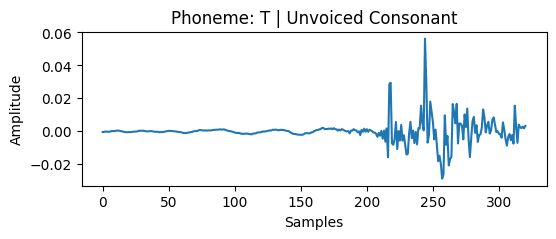

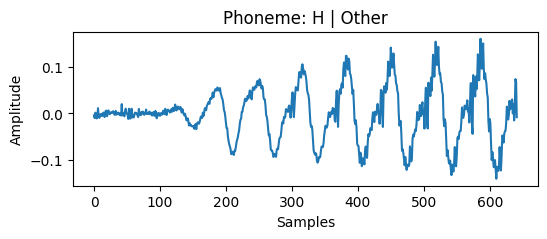

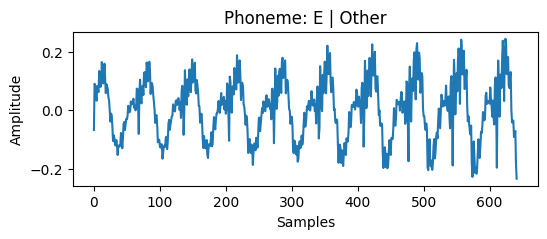

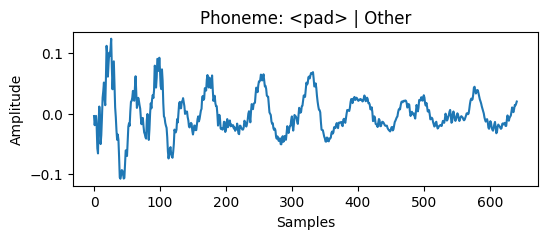

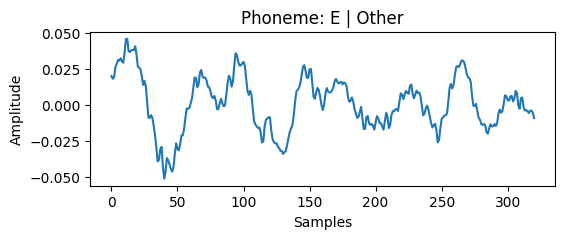

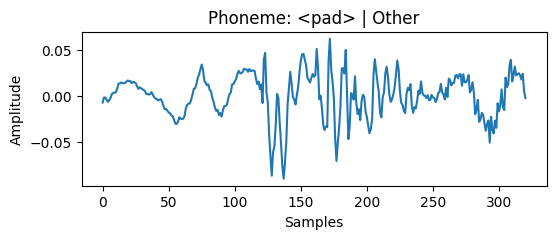

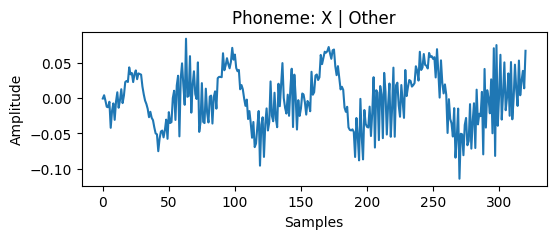

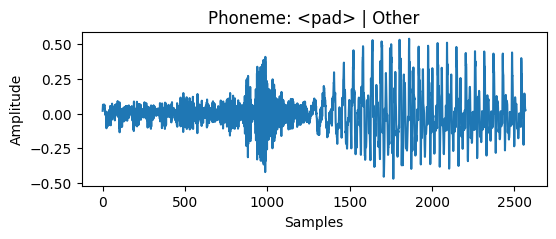

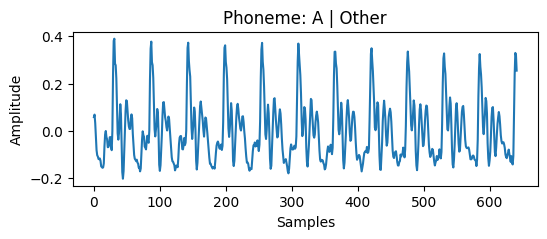

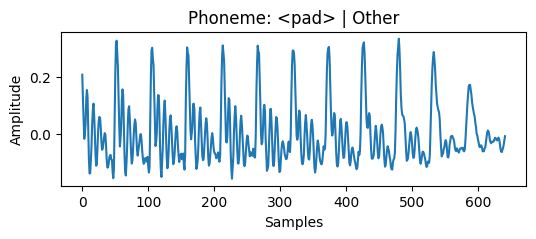

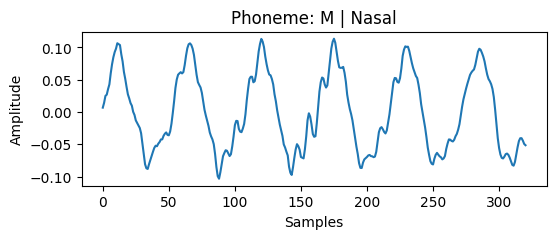

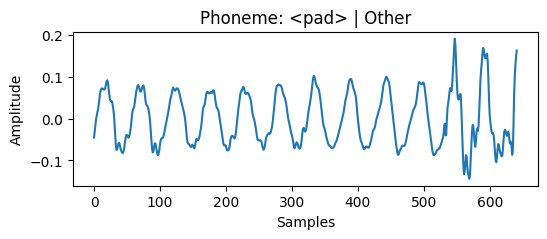

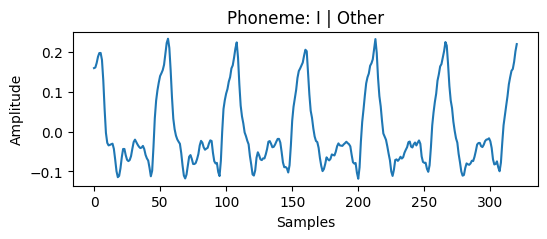

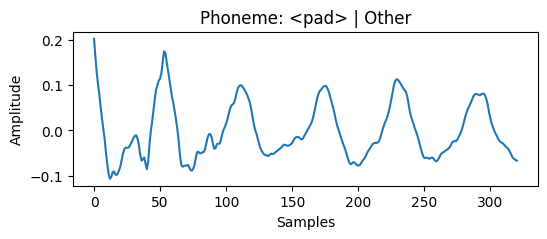

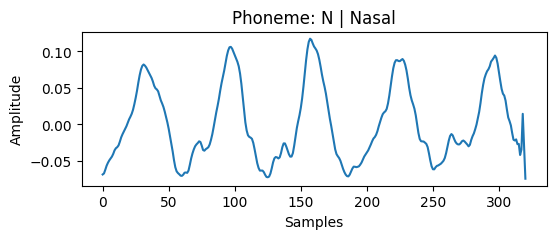

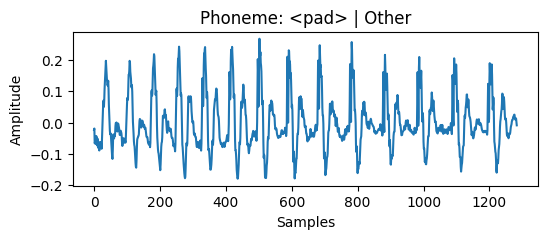

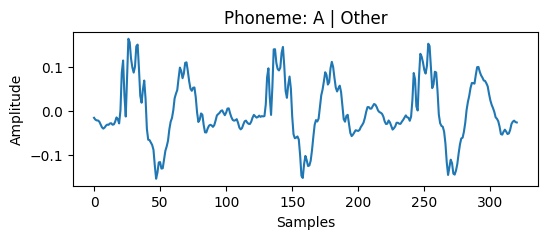

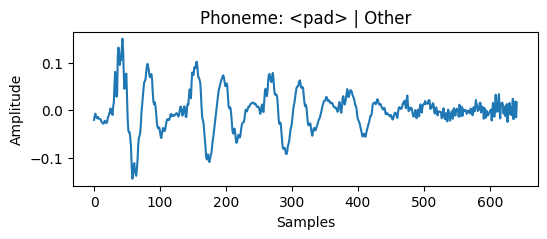

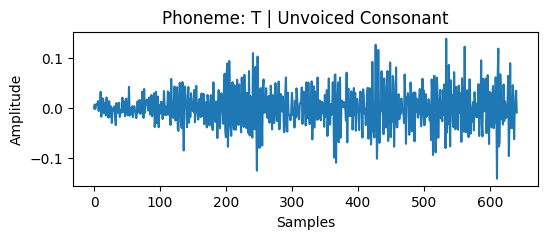

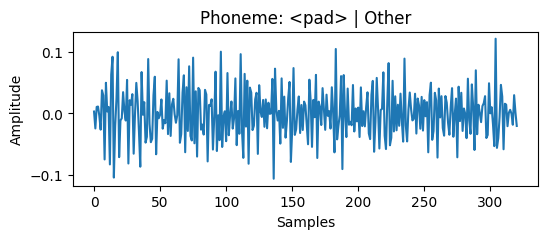

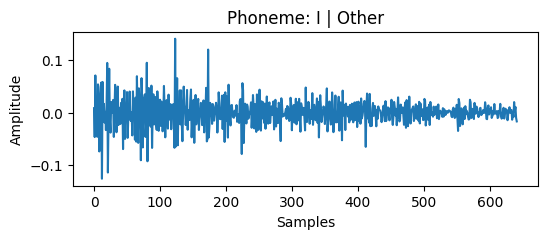

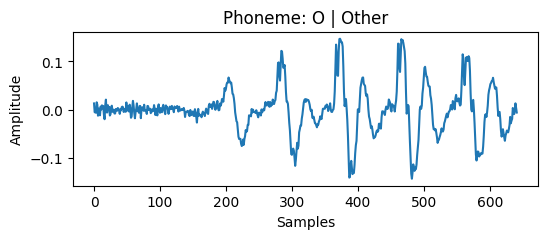

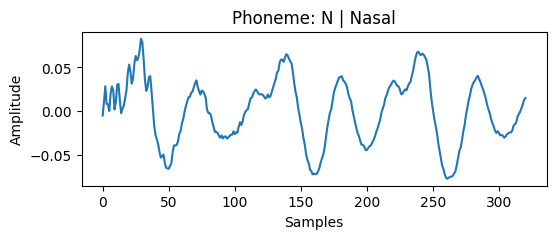

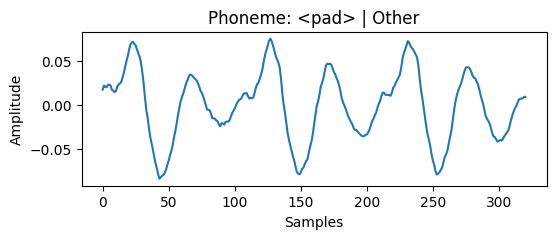

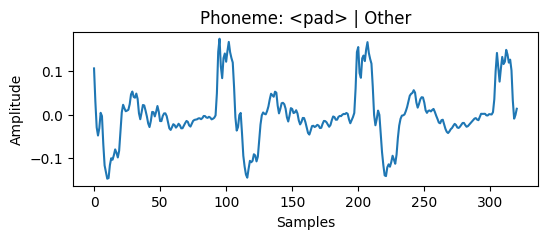

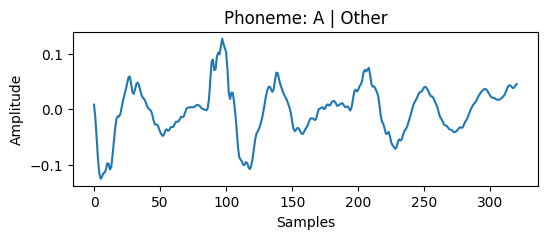

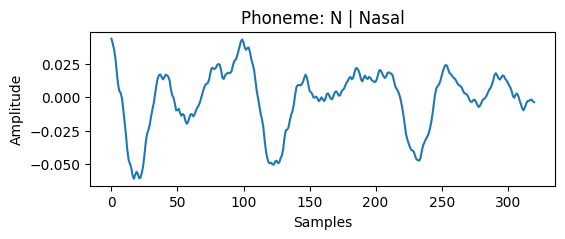

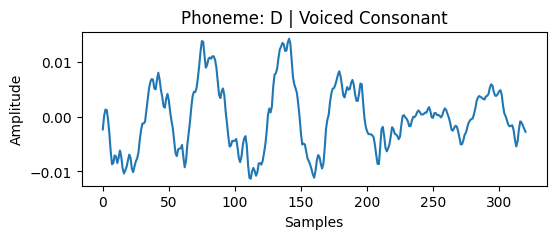

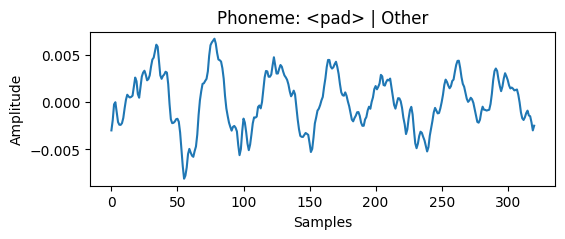

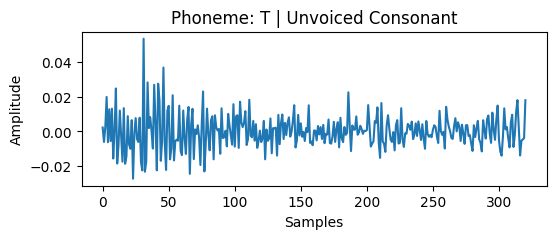

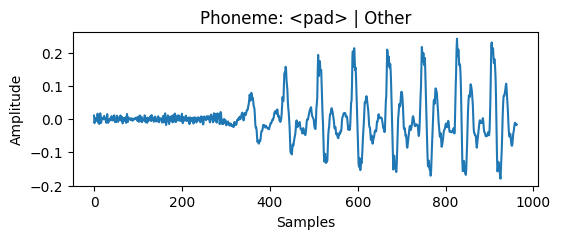

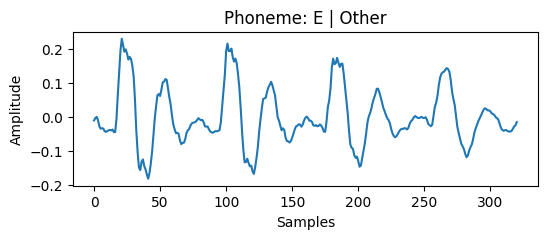

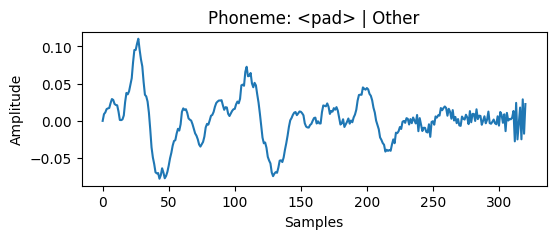

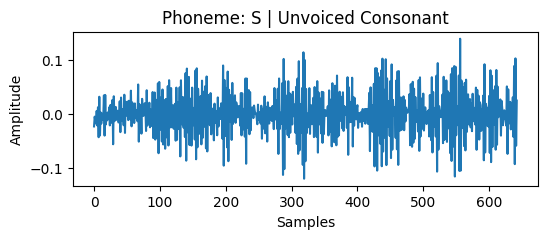

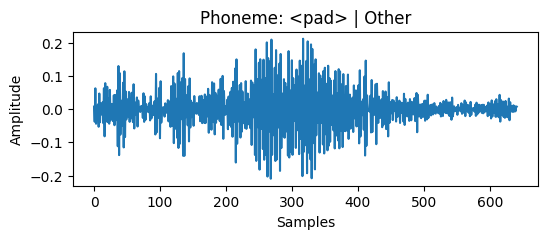

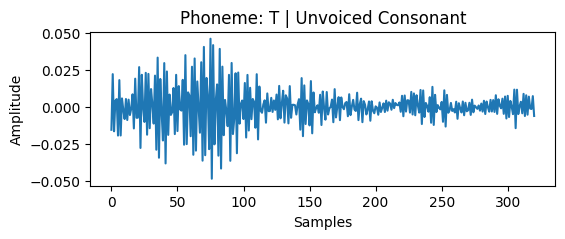

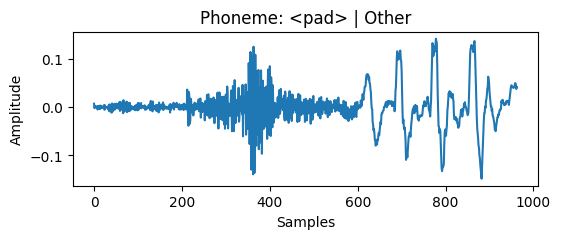

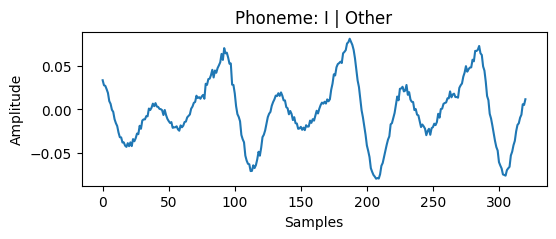

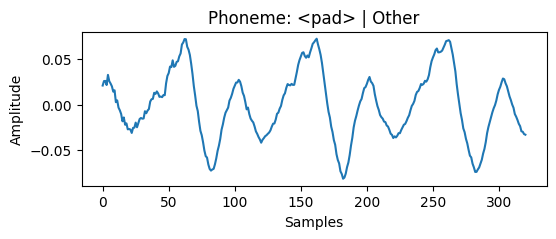

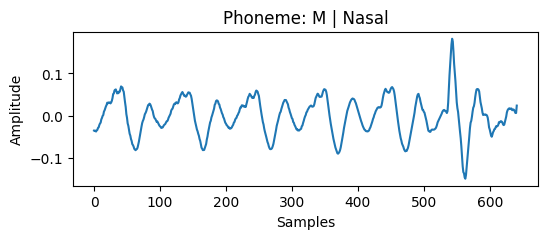

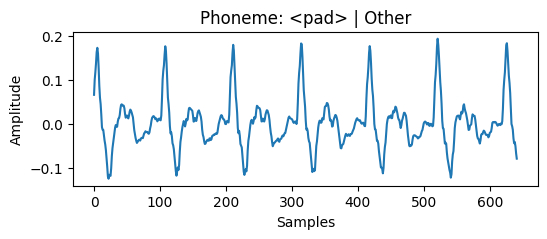

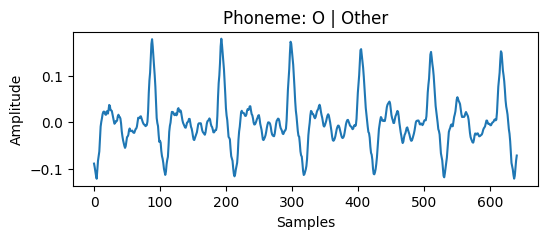

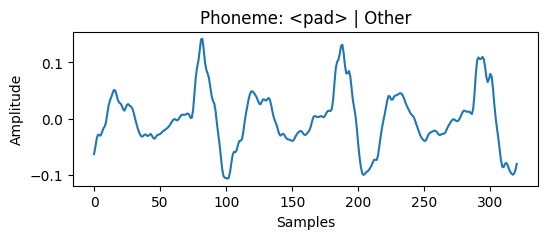

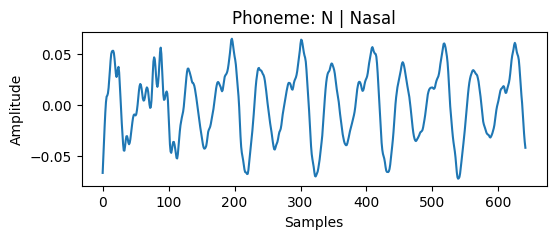

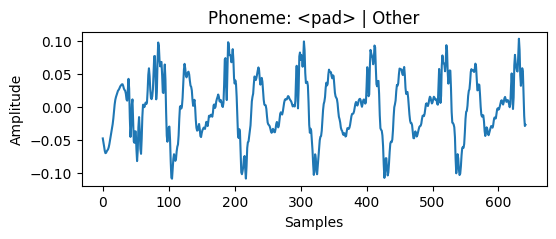

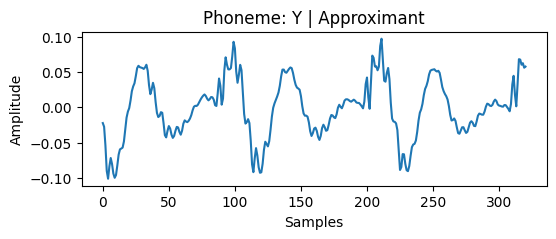

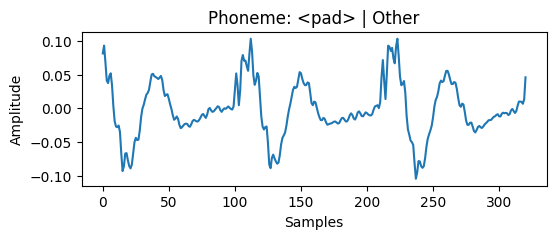

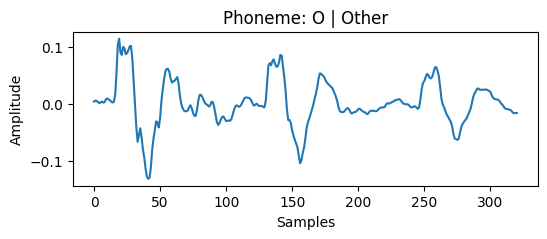

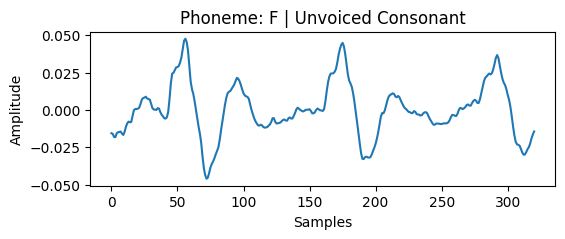

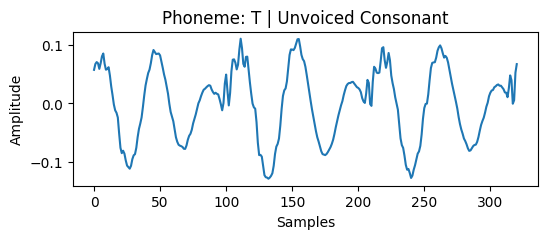

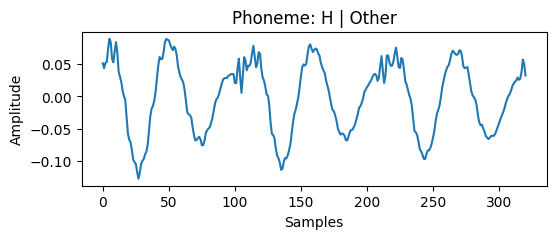

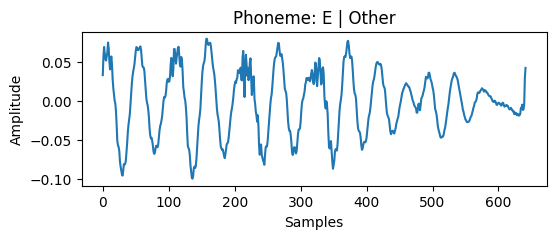

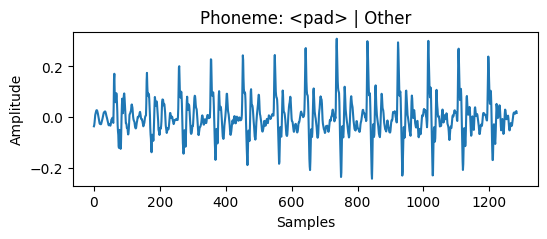

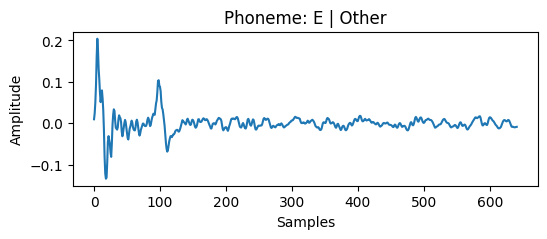

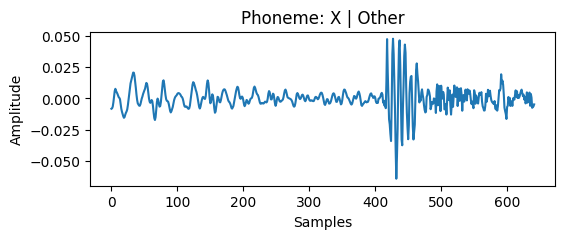

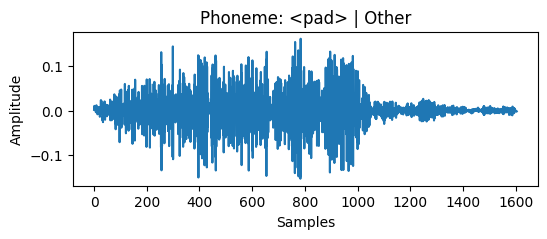

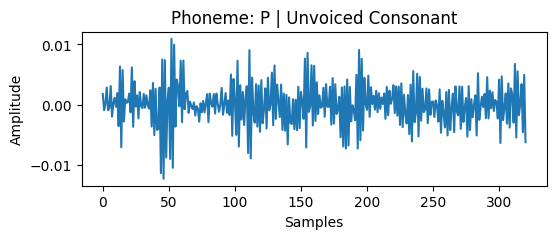

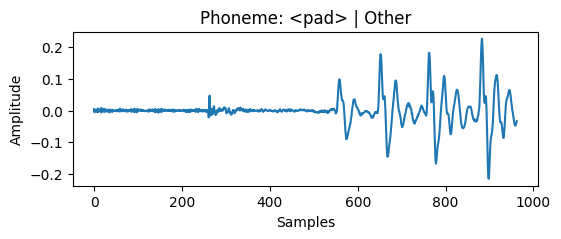

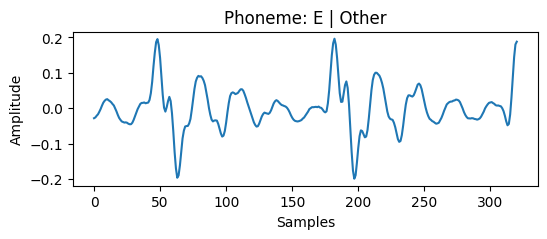

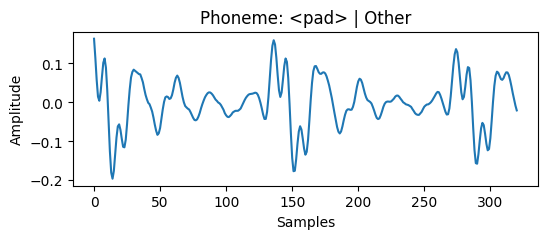

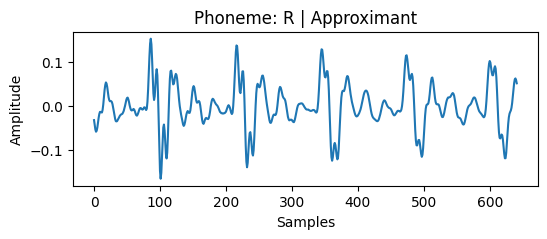

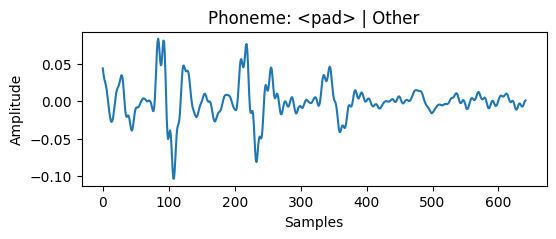

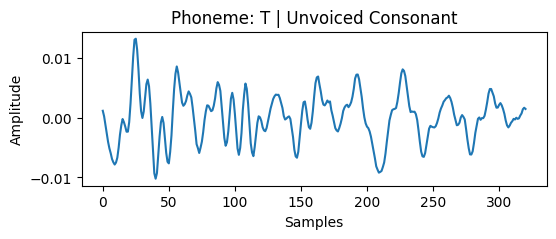

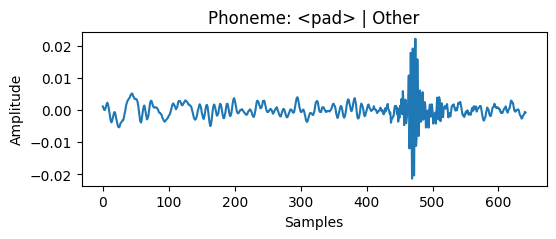

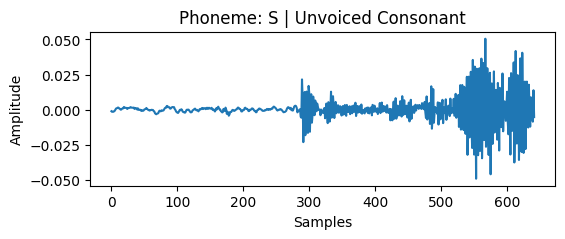

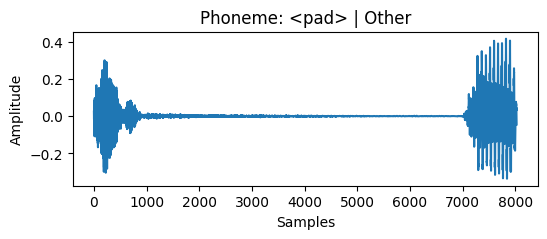

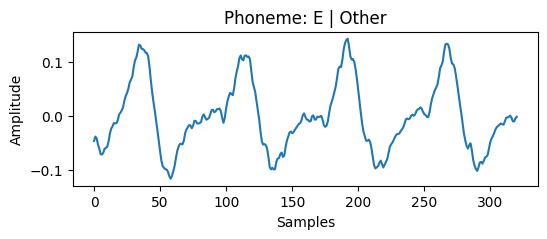

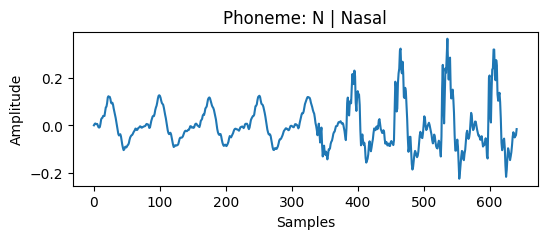

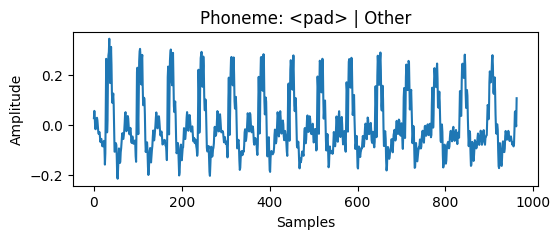

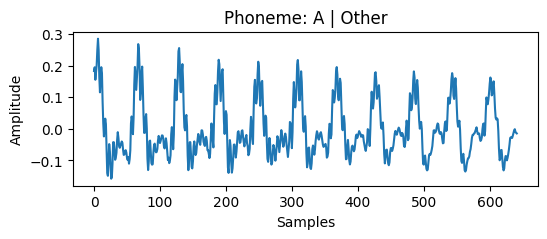

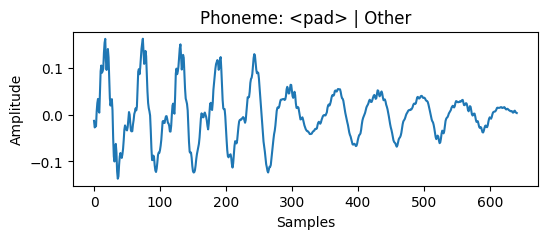

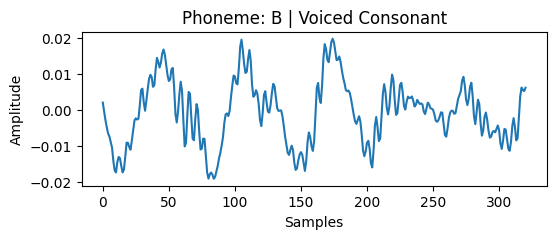

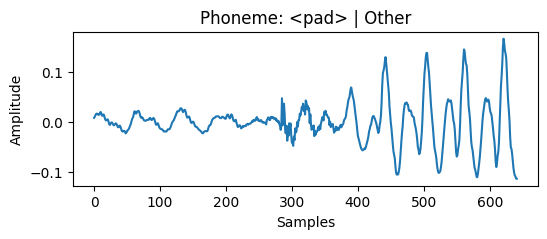

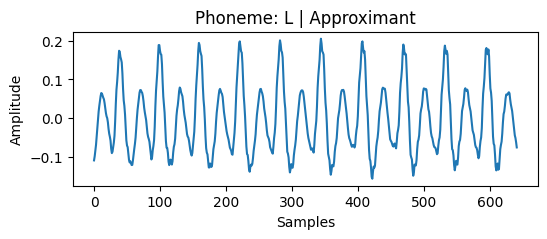

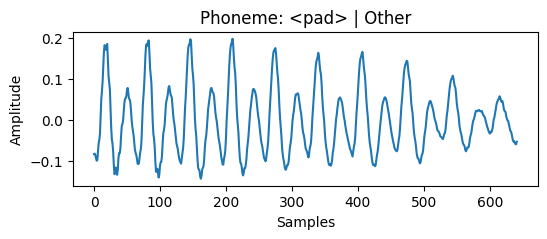

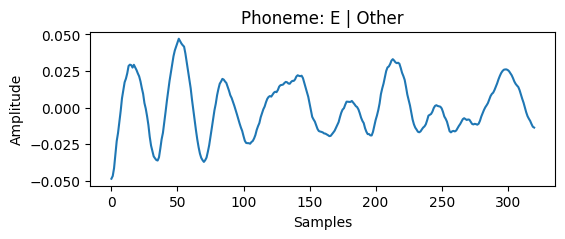

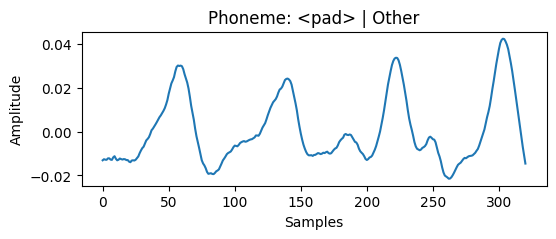

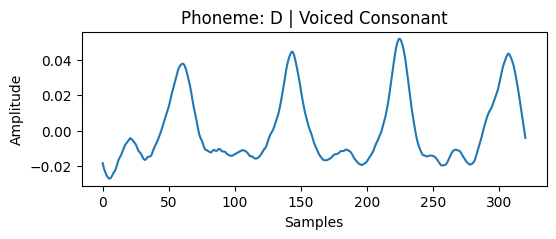

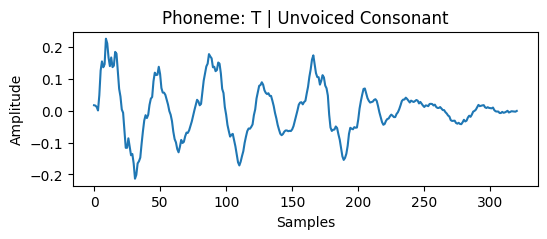

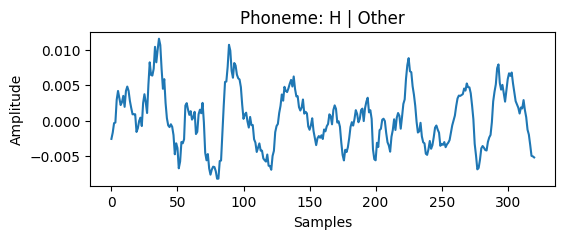

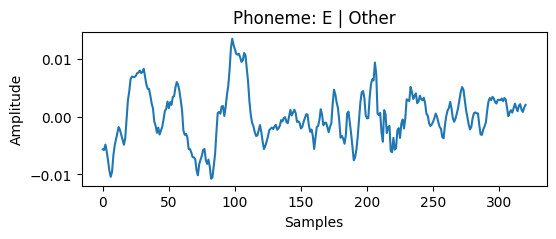

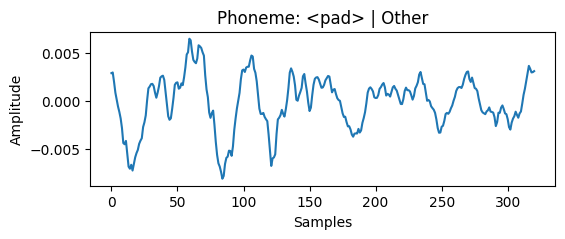

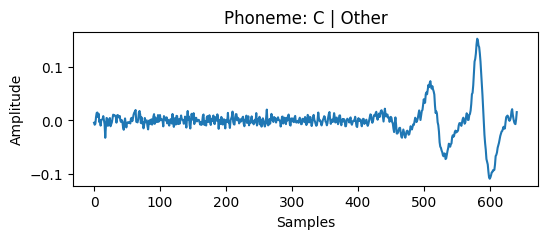

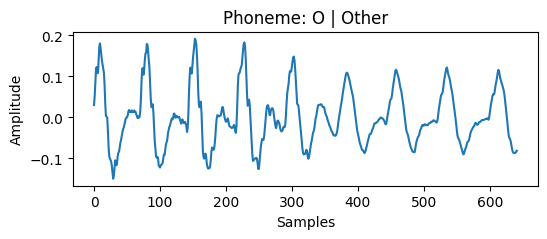

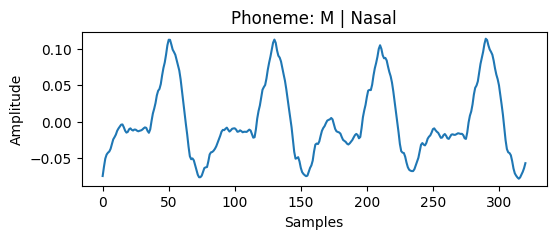

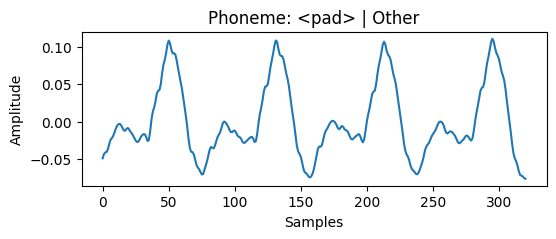

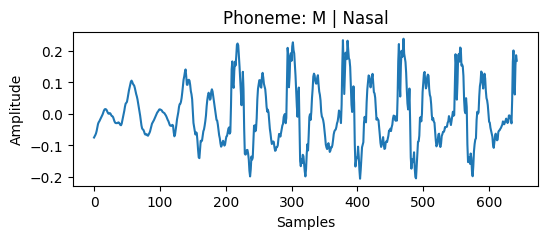

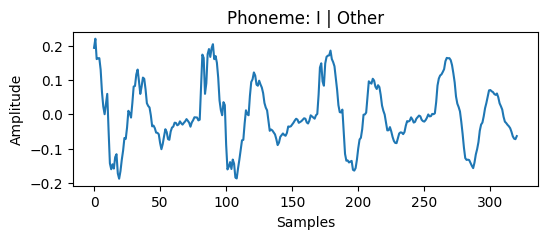

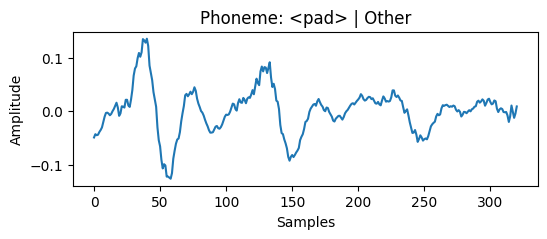

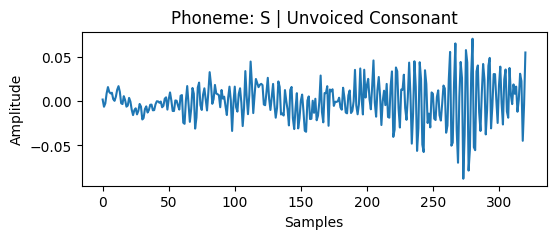

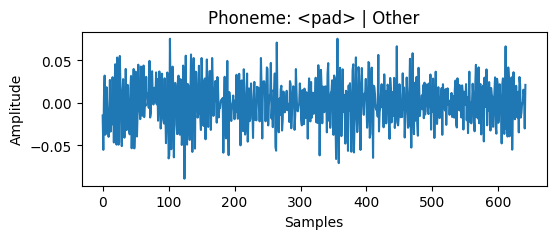

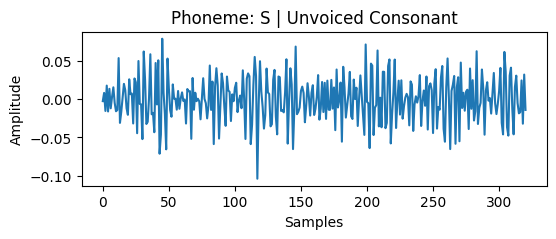

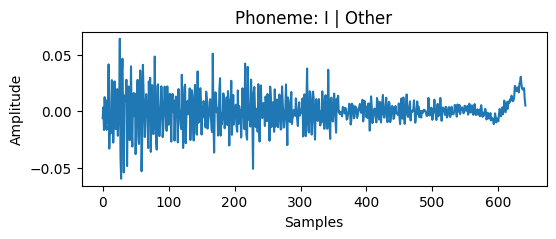

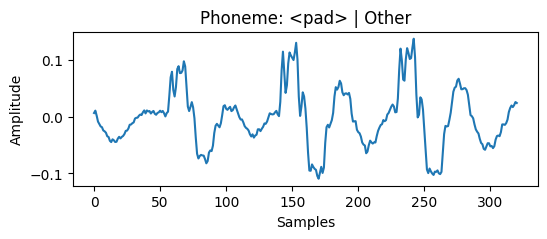

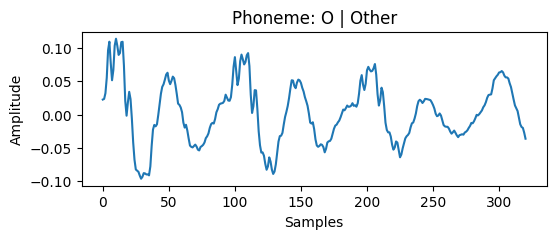

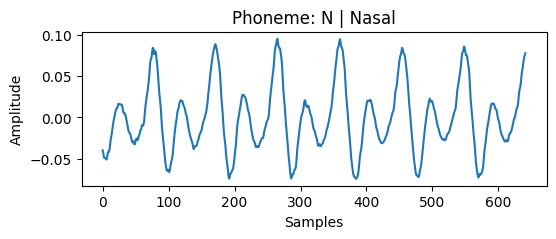

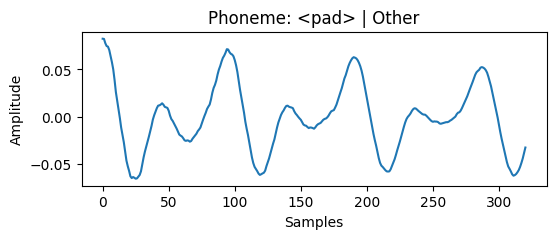

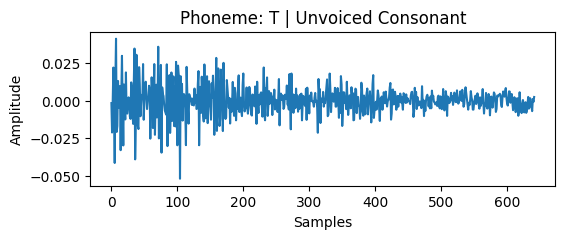

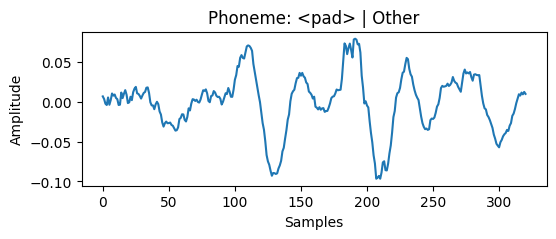

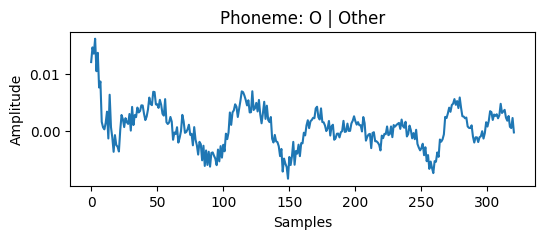

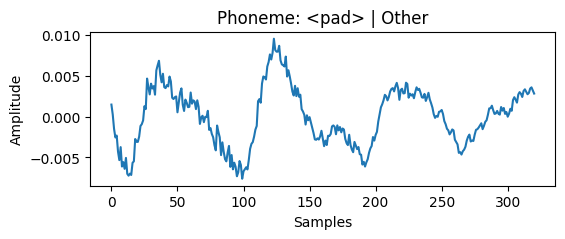

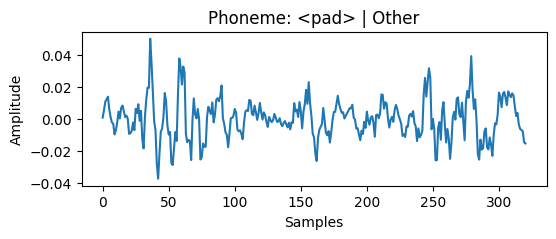

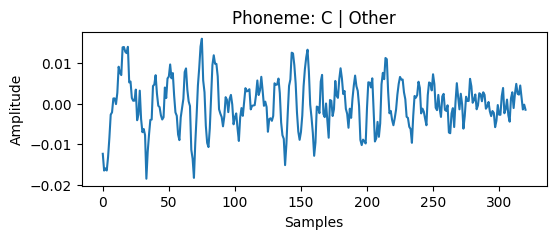

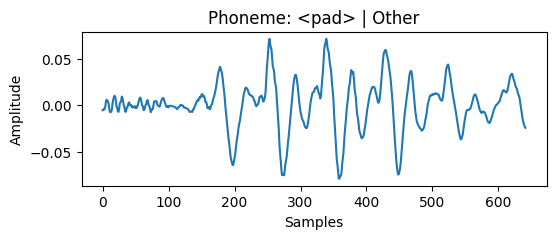

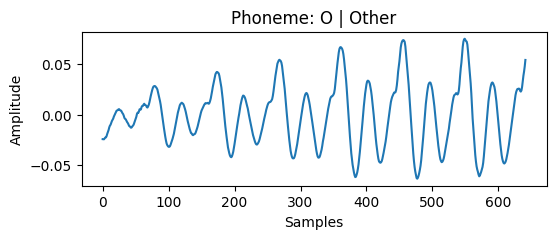

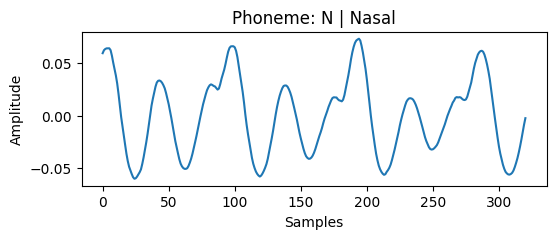

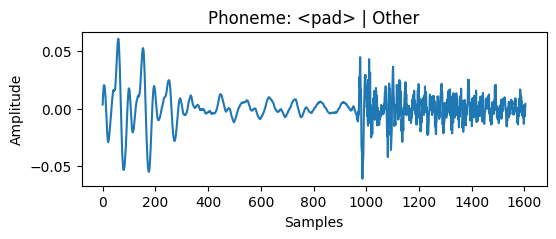

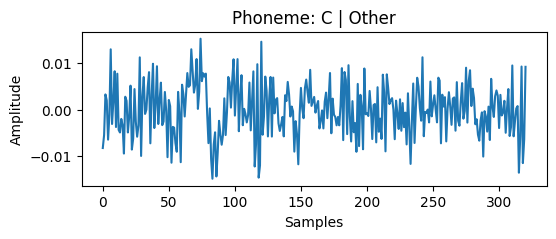

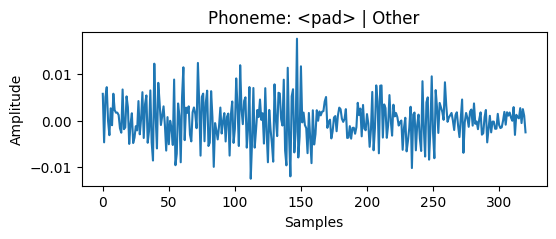

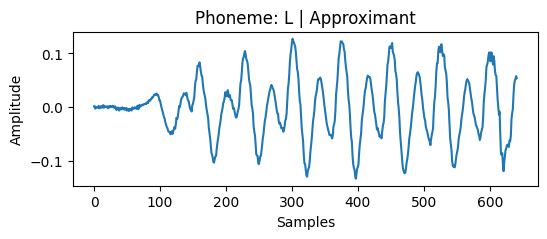

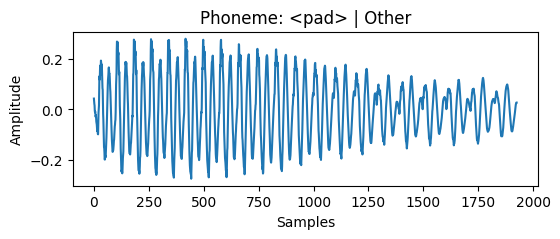

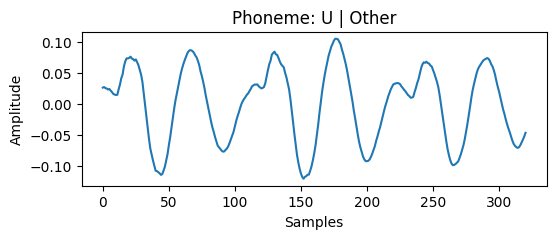

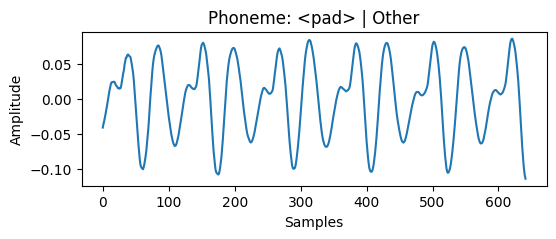

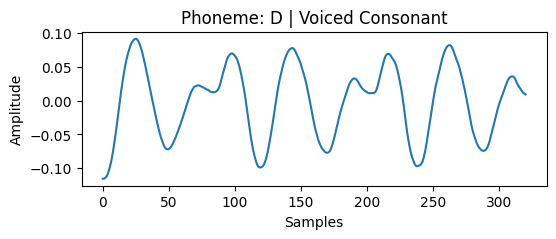

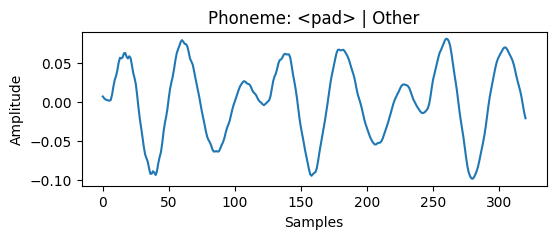

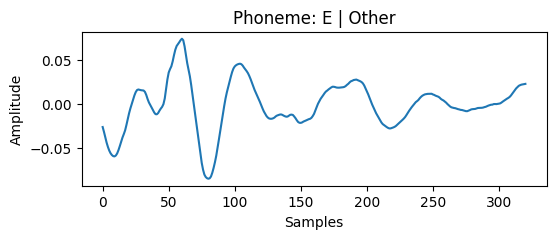

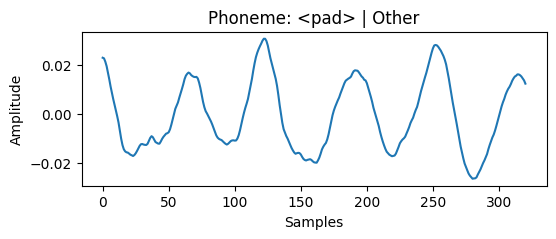

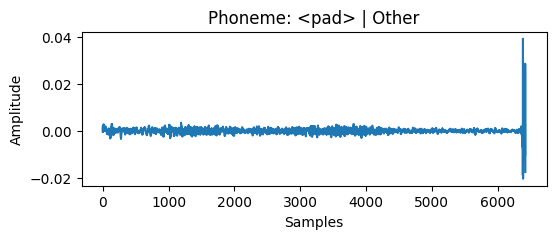

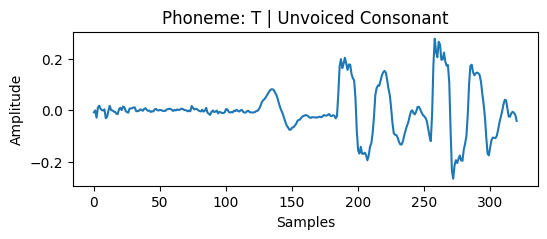

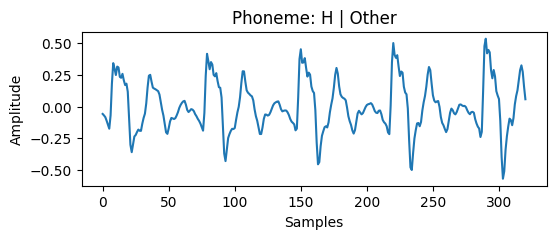

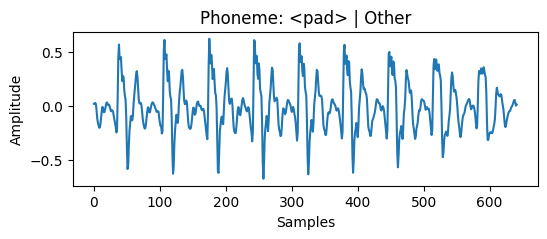

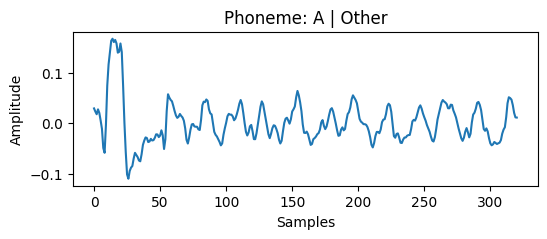

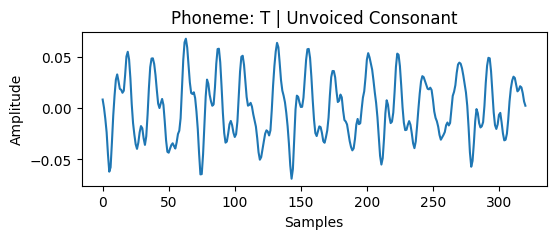

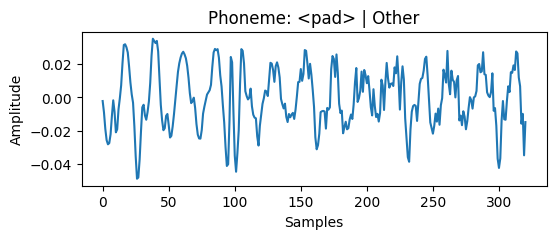

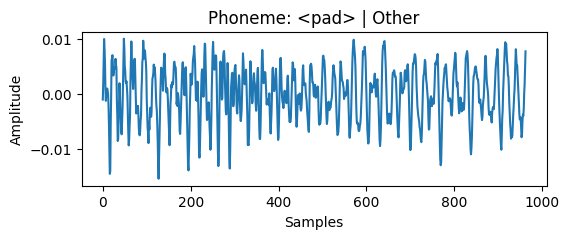

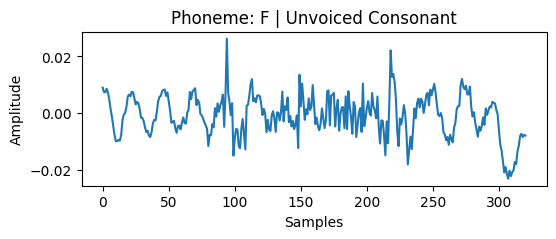

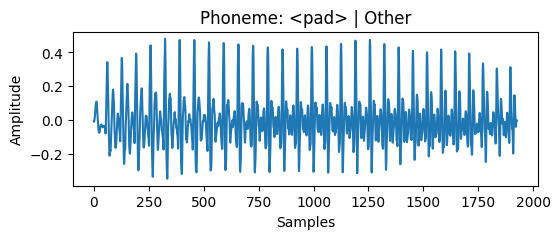

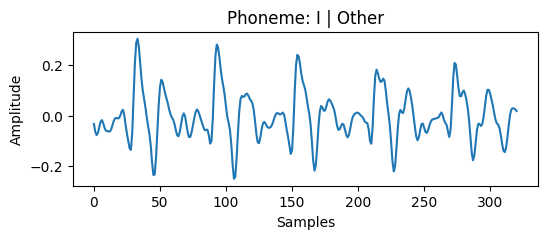

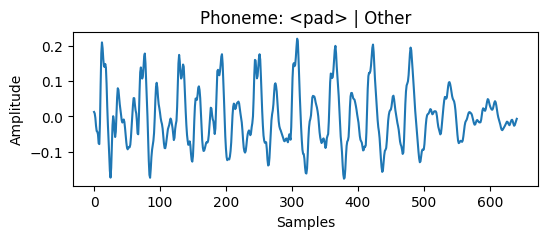

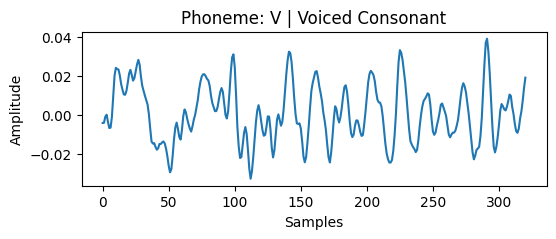

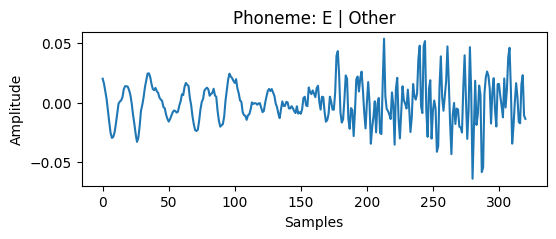

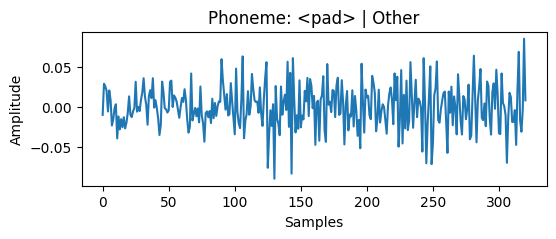

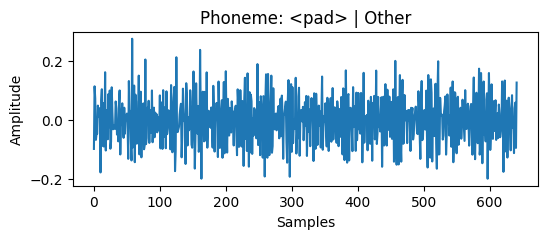

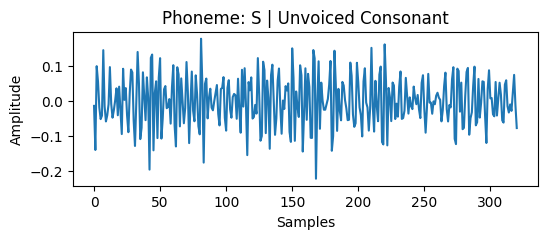

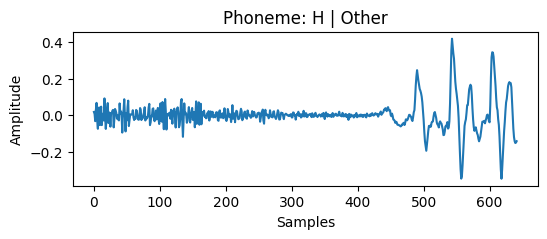

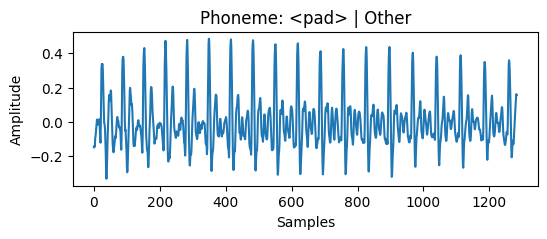

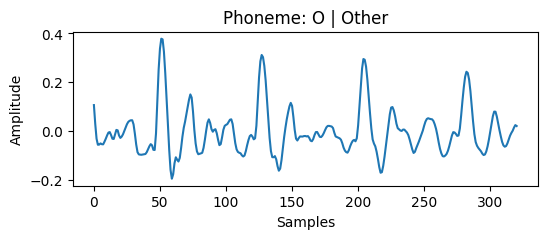

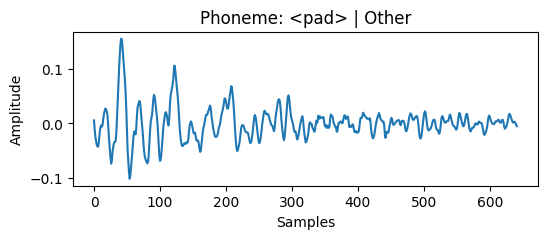

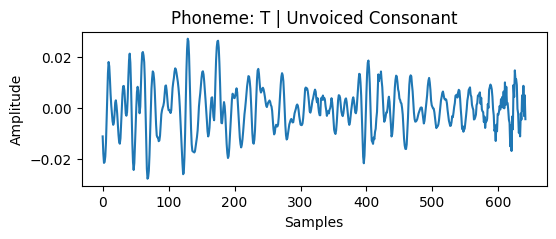

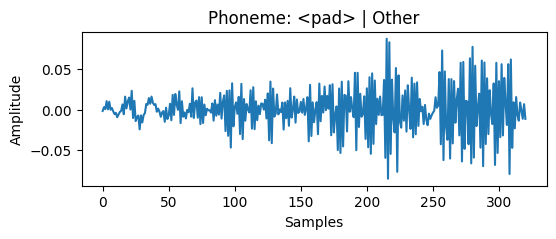

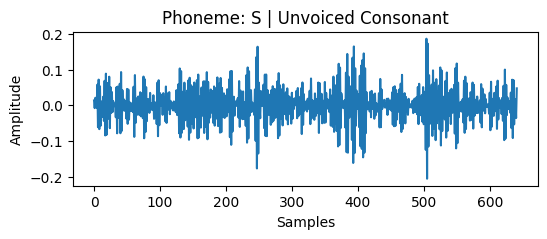

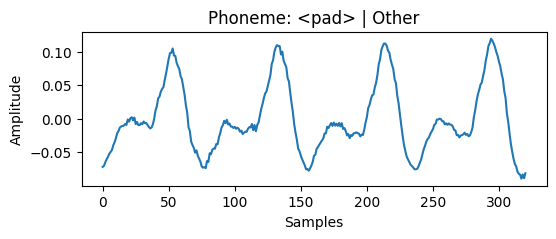

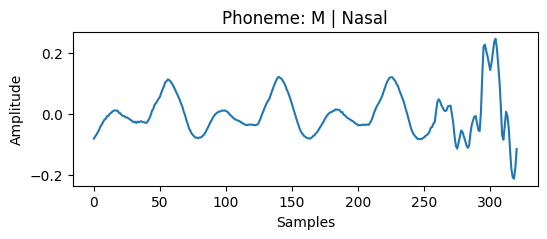

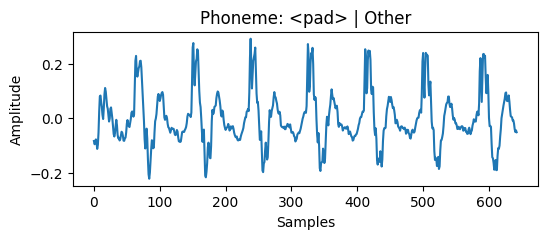

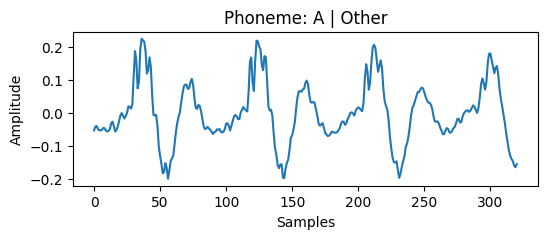

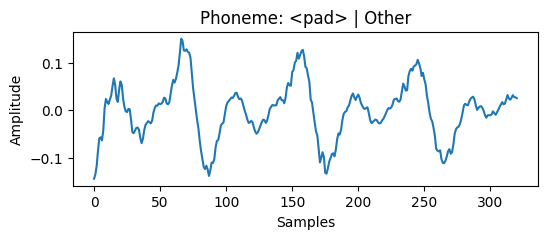

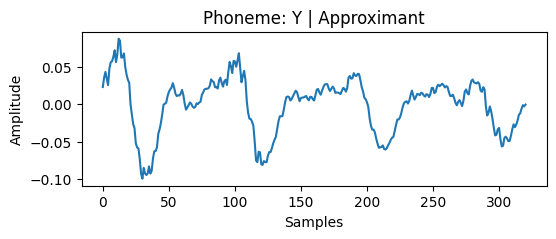

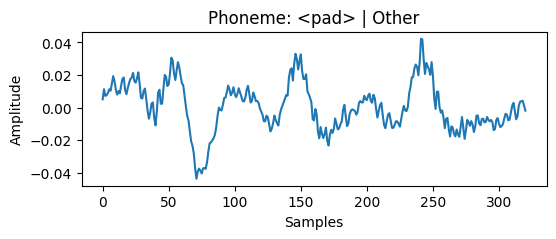

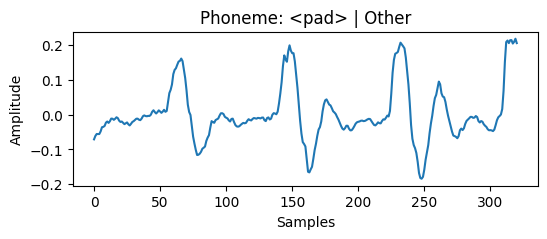

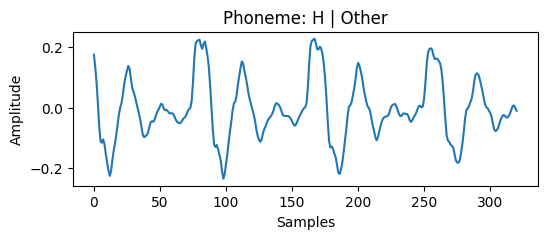

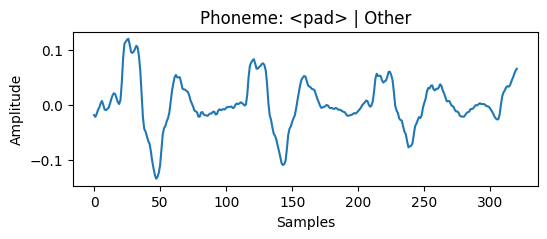

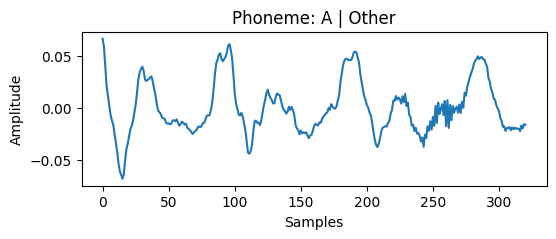

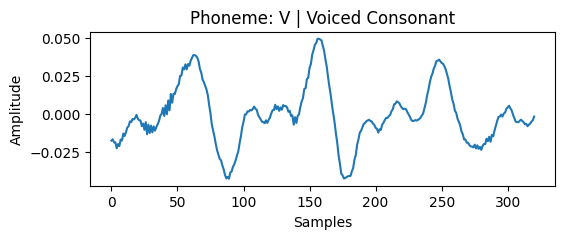

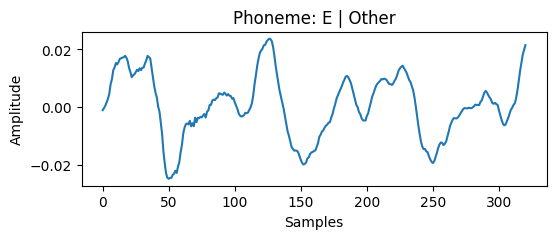

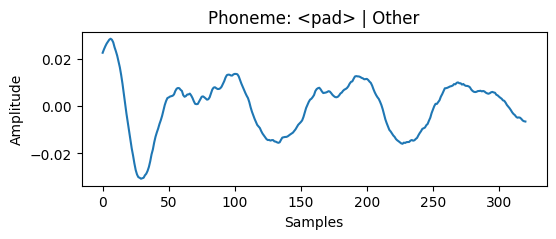

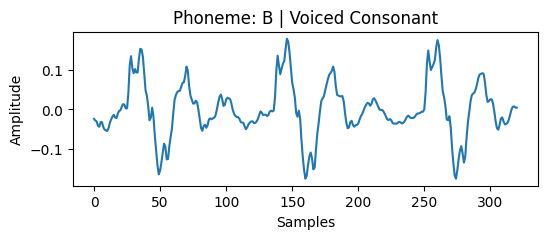

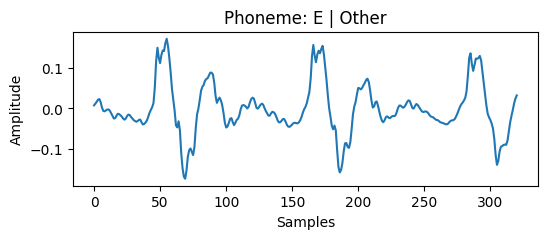

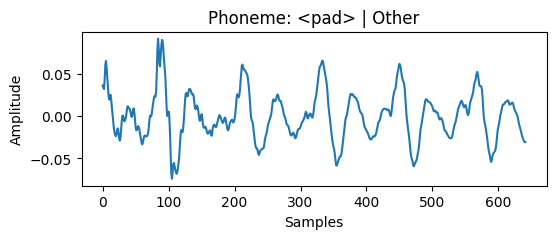

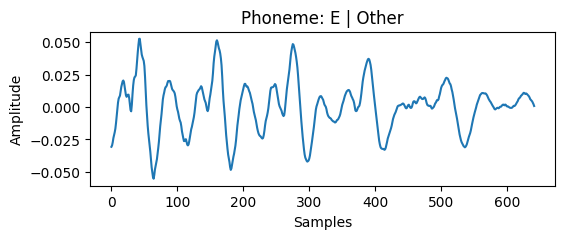

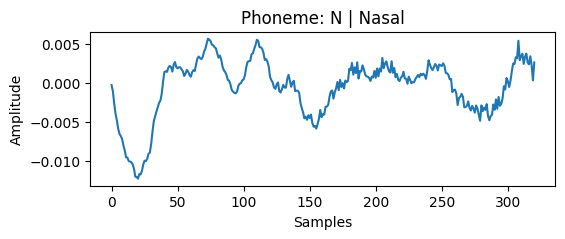

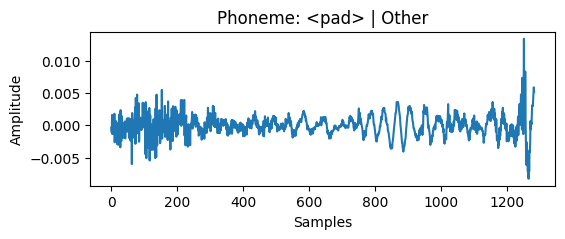

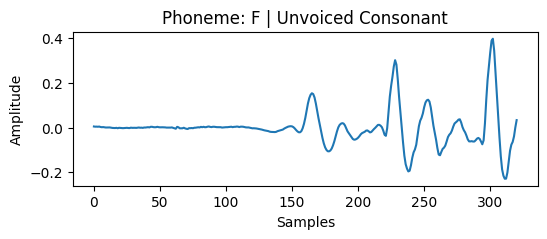

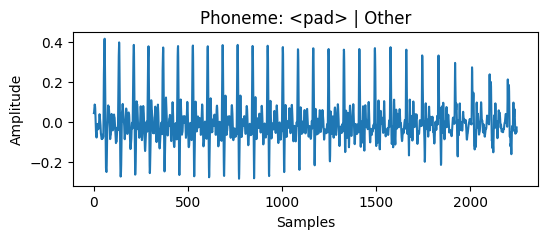

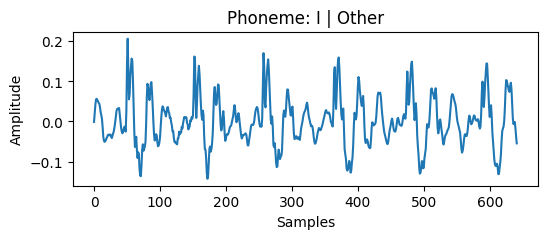

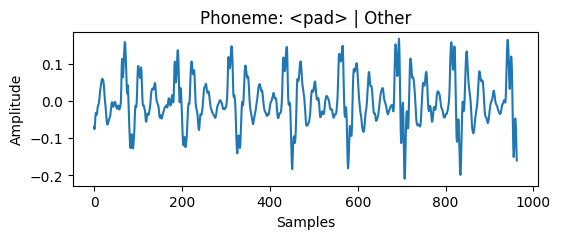

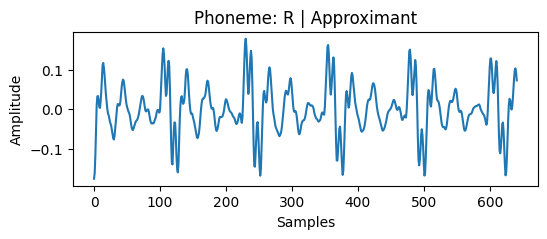

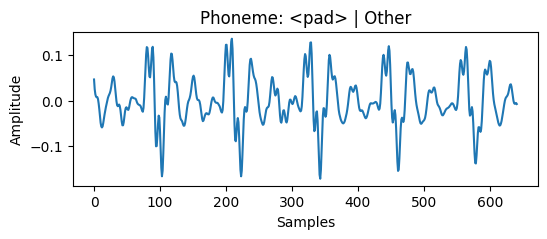

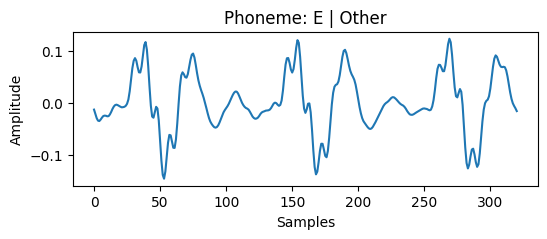

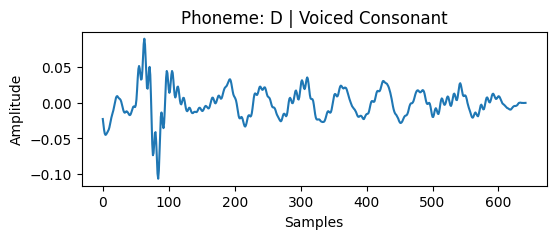

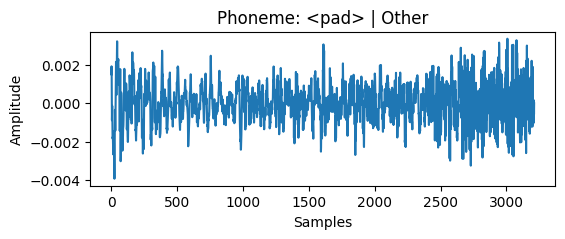

In [7]:
for idx, (ph, t1, t2) in enumerate(phonemes):
    s = int(t1 * sr)
    e = int(t2 * sr)
    segment = audio[s:e]

    if len(segment) < 50:
        continue

    label = phoneme_category(ph)

    sf.write(f"phoneme_{idx}_{ph}.wav", segment, sr)

    plt.figure(figsize=(6,2))
    plt.plot(segment)
    plt.title(f"Phoneme: {ph} | {label}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()

    if "Voiced" in label and voiced_segment is None:
        voiced_segment = segment
    if "Unvoiced" in label and unvoiced_segment is None:
        unvoiced_segment = segment



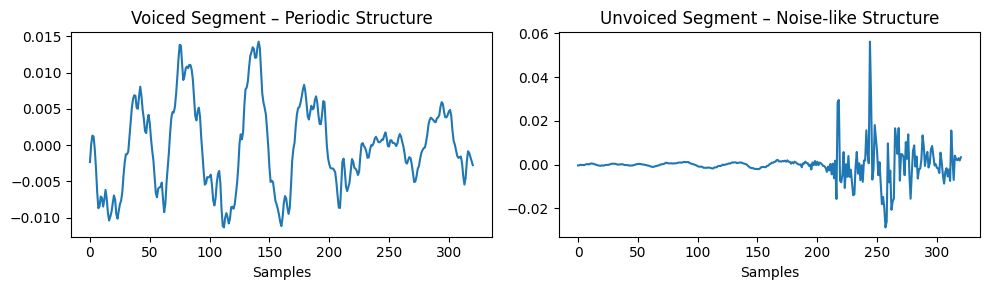

In [8]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(voiced_segment)
plt.title("Voiced Segment – Periodic Structure")
plt.xlabel("Samples")

plt.subplot(1,2,2)
plt.plot(unvoiced_segment)
plt.title("Unvoiced Segment – Noise-like Structure")
plt.xlabel("Samples")

plt.tight_layout()
plt.show()


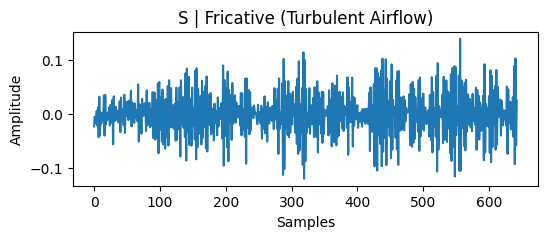

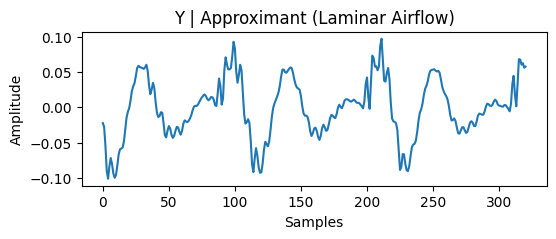

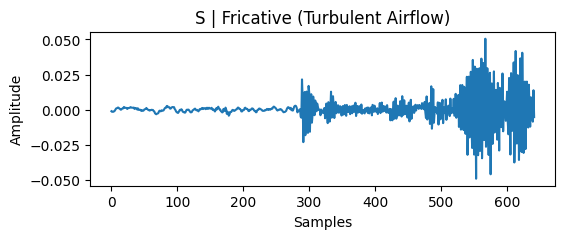

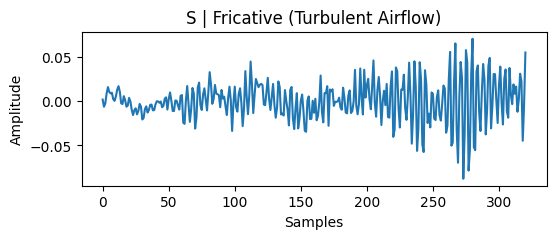

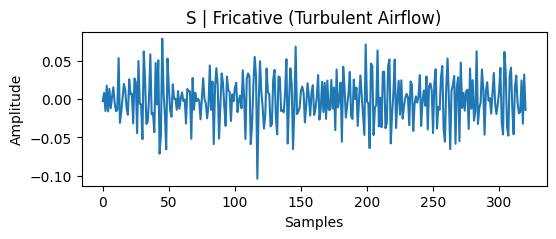

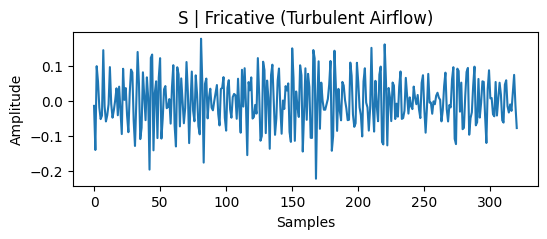

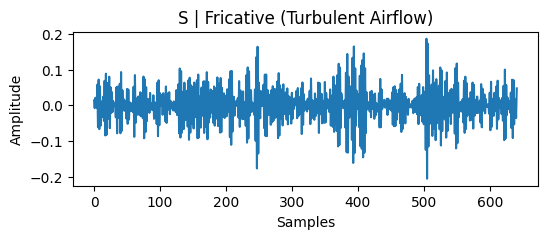

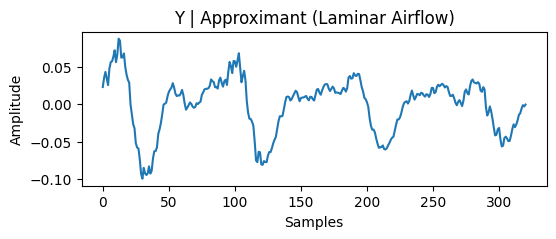

In [9]:
fricatives = ["S", "SH", "Z"]
approximants = ["Y", "J"]

for ph, t1, t2 in phonemes:
    if ph in fricatives or ph in approximants:
        s = int(t1 * sr)
        e = int(t2 * sr)
        segment = audio[s:e]

        if len(segment) < 50:
            continue

        plt.figure(figsize=(6,2))
        plt.plot(segment)
        plt.title(
            f"{ph} | {'Fricative (Turbulent Airflow)' if ph in fricatives else 'Approximant (Laminar Airflow)'}"
        )
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

